In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import MetaTrader5 as mt5
import pytz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [3]:
# connect to the trade account without specifying a password and a server
account=511899
authorized=mt5.login(account, password= "Your_password", server="MT5-Live01", path= "C:\Program Files\MetaTrader 5\terminal64.exe")  

# the terminal database password is applied if connection data is set to be remembered
if authorized:
    account_info_dict =mt5.account_info()._asdict()
    for prop in account_info_dict:
        print(" {}={}".format(prop, account_info_dict[prop]))
else:
    print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))
    

 login=511899
 trade_mode=2
 leverage=200
 limit_orders=500
 margin_so_mode=0
 trade_allowed=True
 trade_expert=True
 margin_mode=2
 currency_digits=2
 fifo_close=False
 balance=147.55
 credit=0.0
 profit=-0.22
 equity=147.33
 margin=21.69
 margin_free=125.64
 margin_level=679.253112033195
 margin_so_call=90.0
 margin_so_so=50.0
 margin_initial=0.0
 margin_maintenance=0.0
 assets=0.0
 liabilities=0.0
 commission_blocked=0.0
 name=
 server=MT5-Live01
 currency=USD
 company=Group Limited


In [4]:
# Define the parameters for data download 
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M5
utc_from = datetime(2023, 1, 1)
utc_to = datetime.now()

# Download the historic data 
rates = mt5.copy_rates_range(symbol, timeframe, utc_from, utc_to)

# Convert the data into a DataFrame using pandas
data = pd.DataFrame(rates)
data['time'] = pd.to_datetime(data['time'], unit='s')
data.set_index('time', inplace=True)

# Apply the close data normalization 
scaler = MinMaxScaler()
data['close_normalized'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

In [5]:
#  Preprocess the data (Features)
window_size = 15  # Window size of historic data 
data['close'] = data['close'].astype(float)  # Make sure that the prices are in numeric format
data['close_shifted'] = data['close'].shift(-1)  # Create the column with shifted prices 

# Eliminate the last row that contains  NaN on close_shifted
data = data.dropna(subset=['close_shifted'])

X = []
y = []
for i in range(len(data) - window_size):
    X.append(data['close'][i:i+window_size].values)
    y.append(data['close_shifted'][i+window_size])

X = np.array(X)
y = np.array(y)

In [6]:
# Divide the data into train,validation and test 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [7]:
print(X.shape)

(50100, 15)


In [8]:
# Create the LSTM mpdel
model = Sequential()
model.add(LSTM(units=65, input_shape=(X.shape[1], 1)))  # Usar X.shape[1] y 1 para características
model.add(Dense(units=1))
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the callback of ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='mm_fx15.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             mode='min',
                             verbose=1)

# Train the model with callbacks
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/30
462/470 [============================>.] - ETA: 0s - loss: 0.0132
Epoch 1: val_loss improved from inf to 0.00001, saving model to mm_fx15.h5
470/470 [==============================] - 5s 8ms/step - loss: 0.0129 - val_loss: 1.0028e-05
Epoch 2/30
463/470 [============================>.] - ETA: 0s - loss: 1.0446e-05
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to mm_fx15.h5
470/470 [==============================] - 3s 7ms/step - loss: 1.0447e-05 - val_loss: 9.4606e-06
Epoch 3/30
464/470 [============================>.] - ETA: 0s - loss: 9.3789e-06
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to mm_fx15.h5
470/470 [==============================] - 3s 7ms/step - loss: 9.3713e-06 - val_loss: 7.0535e-06
Epoch 4/30
467/470 [============================>.] - ETA: 0s - loss: 8.1585e-06
Epoch 4: val_loss improved from 0.00001 to 0.00001, saving model to mm_fx15.h5
470/470 [==============================] - 3s 7ms/step - loss: 8.1526e-06 - val_l

314/314 [==============================] - 1s 2ms/step


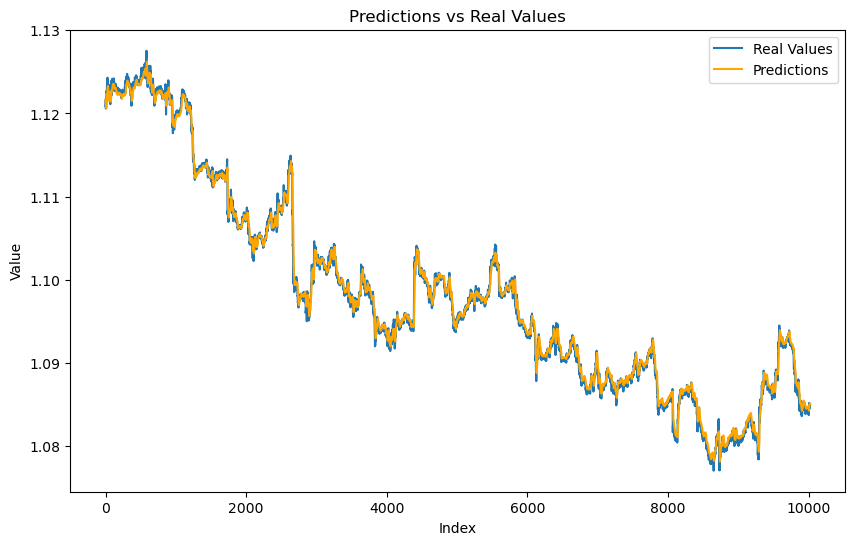

In [9]:

# Load the best saved model 
best_model = load_model('mm_fx15.h5')

# Make predictions on test data 
predictions = best_model.predict(X_test)

# Graph the predictions vs real values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real Values')
plt.plot(predictions, label='Predictions', color='orange')
plt.title('Predictions vs Real Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


314/314 [==============================] - 1s 2ms/step


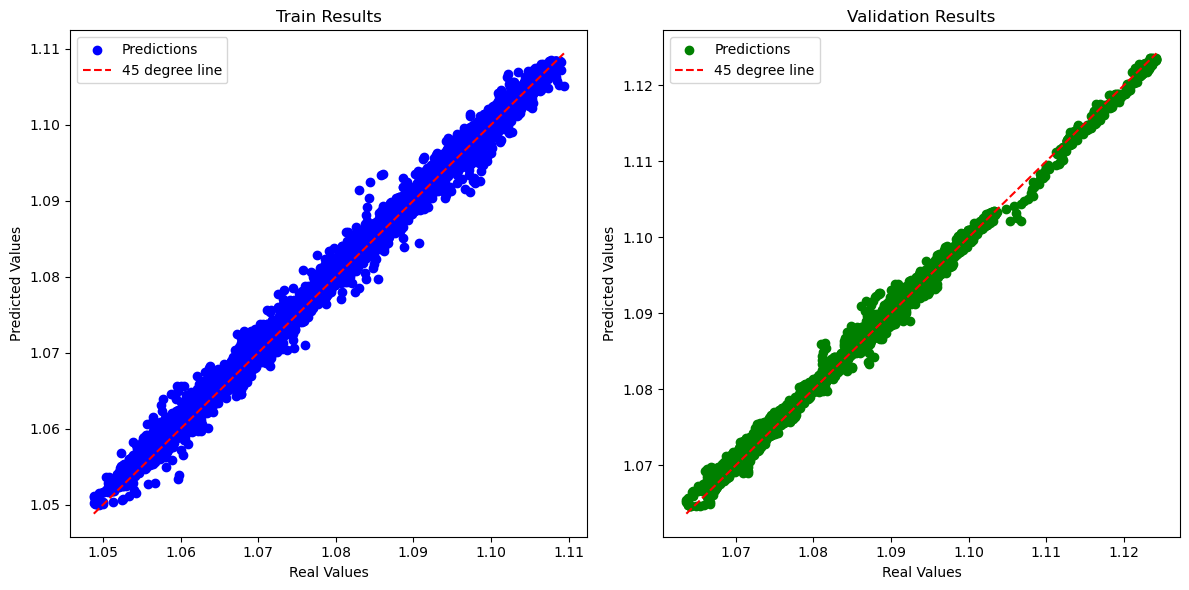

In [10]:


# Obtain the predictions of the model in the train and validation sets 
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Graph the train results 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, c='blue', label='Predictions')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', label='45 degree line')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Train Results')
plt.legend()

# Graph the Validation results 
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred, c='green', label='Predictions')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', label='45 degree line')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Validation Results')
plt.legend()

plt.tight_layout()
plt.show()


314/314 [==============================] - 1s 2ms/step


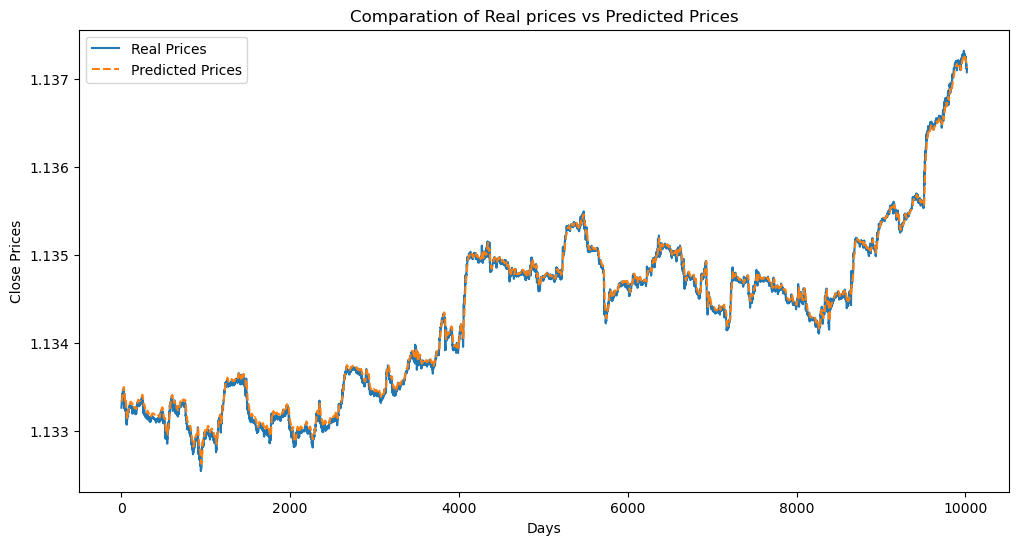

In [11]:
# Make the predictions with the LSTM model 
predicted_prices = model.predict(X_val)

# Inverse the normalization to obtain the real predicted prices 
predicted_prices_real = scaler.inverse_transform(predicted_prices)

# Inverse the normalization of real values
actual_prices_real = scaler.inverse_transform(y_val.reshape(-1, 1))

# Graph the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices_real, label='Real Prices')
plt.plot(predicted_prices_real, label='Predicted Prices', linestyle='dashed')
plt.title('Comparation of Real prices vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()


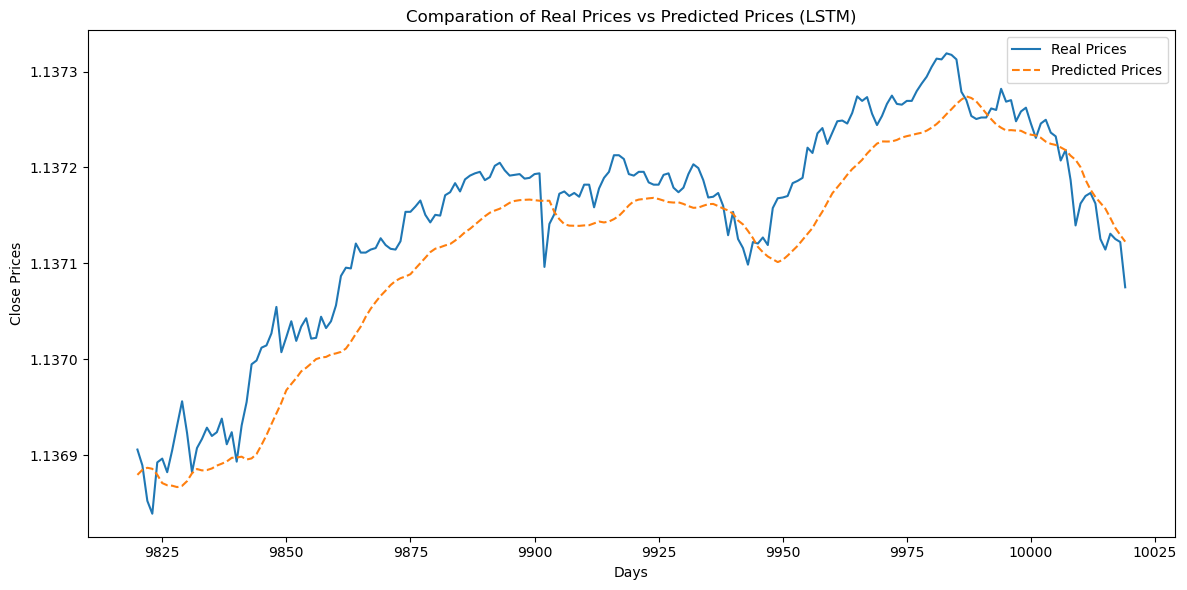

In [12]:
# Get the last 200 prices
last_200_actual_prices = actual_prices_real[-200:]
last_200_predicted_prices = predicted_prices_real[-200:]

# Create a list of values to intervals on x axis (last 200 data) 
x_intervals = list(range(len(actual_prices_real) - 200, len(actual_prices_real)))

# Graph the results of last 200 values 
plt.figure(figsize=(12, 6))
plt.plot(x_intervals, last_200_actual_prices, label='Real Prices')
plt.plot(x_intervals, last_200_predicted_prices, label='Predicted Prices', linestyle='dashed')
plt.title('Comparation of Real Prices vs Predicted Prices (LSTM)')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.tight_layout()
plt.show()
